In [83]:
import pandas as pd

df = pd.read_csv("Bugs.csv")

In [84]:
df.head()

,SourceTimeZone,ProjectId,BugId,IssueType,Priority,Severity,PlatformFound,GameArea,TestTeam,CreatedTime_Local,CreatedTime_UTC,EstimatedBugFind,AssignedTime_Local,AssignedTime_UTC
0,Pacific Standard Time,1519,10001,MD (Milestone Deliverable),NaN,NaN,Common,GAA,TT1,12:20 PM 4-3-2015,7:20 PM 4-3-2015,NaN,4:16 PM 5-1-2015,11:16 PM 5-1-2015
1,Pacific Standard Time,1519,10002,MD (Milestone Deliverable),NaN,,Common,GAA,TT1,12:21 PM 4-3-2015,7:21 PM 4-3-2015,NaN,4:16 PM 5-1-2015,11:16 PM 5-1-2015
2,Pacific Standard Time,1519,10003,MD (Milestone Deliverable),NaN,,Common,GAA,TT1,12:21 PM 4-3-2015,7:21 PM 4-3-2015,NaN,4:16 PM 5-1-2015,11:16 PM 5-1-2015
3,Pacific Standard Time,1519,10004,PR - Problem Report,3 - High,C,Common,GAB,TT2,12:21 PM 4-3-2015,7:21 PM 4-3-2015,NaN,7:37 AM 5-22-2015,2:37 PM 5-22-2015
4,Pacific Standard Time,1519,10005,PR - Problem Report,NaN,C,PC,GAC,TT3,12:28 PM 4-3-2015,7:28 PM 4-3-2015,NaN,11:31 AM 5-28-2015,6:31 PM 5-28-2015


In [86]:
df['BugId'].nunique()

100

In [81]:
import numpy as np
df1=df[df['IssueType']=='PR - Problem Report']
df1=df1[pd.isnull(df1['Priority'])]

In [82]:
df1.shape

(40, 14)

## 1. a) Please provide the SQL query that would accurately join the provided tables: ‘Bugs’, ‘BugTracking’, and ‘ProgressStatusLookup’

select SourceTimeZone, b.ProjectId, b.BugId, IssueType, Priority, Severity, PlatformFound, GameArea, 
TestTeam, CreatedTime_Local, CreatedTime_UTC, EstimatedBugFind, AssignedTime_Local, AssignedTime_UTC,
SequenceNo,DateAssigned,Game_Area, ProgressStatusName,ProgressStatusID
from Bugs b 
inner join BugTracking bt 
on b.BugId=bt.BugID
inner join ProgressStatusLookup pr 
on b.ProjectId=pr.ProjectID AND safe_cast(bt.Progress_Status_ID AS NUMERIC)=pr.ProgressStatusID

## 1.b) How many distinct bugs with an ‘In Progress’ progress status exist in this joined table?

with joinedtables as 

(select SourceTimeZone, b.ProjectId, b.BugId, IssueType, Priority, Severity, PlatformFound, GameArea, 
TestTeam, CreatedTime_Local, CreatedTime_UTC, EstimatedBugFind, AssignedTime_Local, AssignedTime_UTC,
SequenceNo,DateAssigned,Game_Area, ProgressStatusName,ProgressStatusID
from EASports.Bugs b 
inner join EASports.BugTracking bt 
on b.BugId=bt.BugID
inner join EASports.ProgressStatusLookup pr 
on b.ProjectId=pr.ProjectID AND safe_cast(bt.Progress_Status_ID AS NUMERIC)=pr.ProgressStatusID)

select count(distinct BugId) as totalbugs
from joinedtables
where ProgressStatusName= "In Progress"
group by ProgressStatusName

Answer:- 45

## 1c) How many distinct bugs have a null value in either the ProgressStatusName or Priority field in the joined table? 

with joinedtables as
(
select SourceTimeZone, b.ProjectId, b.BugId, IssueType, Priority, Severity, PlatformFound, GameArea, 
TestTeam, CreatedTime_Local, CreatedTime_UTC, EstimatedBugFind, AssignedTime_Local, AssignedTime_UTC,
SequenceNo,DateAssigned,Game_Area, ProgressStatusName,ProgressStatusID
from Bugs b 
inner join BugTracking bt 
on b.BugId=bt.BugID
inner join ProgressStatusLookup pr 
on b.ProjectId=pr.ProjectID AND safe_cast(bt.Progress_Status_ID AS NUMERIC)=pr.ProgressStatusID
)

select count(distinct BugId) as totalbugs
from joinedtables
where (ProgressStatusName = 'NULL' or Priority= 'NULL')


-- Answer- 57

## 1 d) i)What is the average Open Bug Life for each Severity Level?


with table0 as 
(select Severity, BugId,DATETIME_DIFF(min(PARSE_DATETIME('%I:%M %p %m-%d-%Y',DateAssigned)), min(PARSE_DATETIME('%I:%M %p %m-%d-%Y',CreatedTime_local)), day) Days
from joinedtables
where ProgressStatusName like "%Closed%" and (Severity ='A' or Severity = 'B' or Severity ='C' or Severity='D')
group by Severity, BugId
order by BugId
)

select Severity, sum(Days)/count(*)avg_days
from table0
group by Severity

Answer -A

## 1 -d- ii) Within the "PR - Problem Report" Issue Type in the table, how many null Priority values are there?

with table1 as
(
select SourceTimeZone, b.ProjectId, b.BugId, IssueType, Priority, Severity, PlatformFound, GameArea, 
TestTeam, CreatedTime_Local, CreatedTime_UTC, EstimatedBugFind, AssignedTime_Local, AssignedTime_UTC,
SequenceNo,DateAssigned,Game_Area, ProgressStatusName,ProgressStatusID
from Bugs b 
inner join BugTracking bt 
on b.BugId=bt.BugID
inner join ProgressStatusLookup pr 
on b.ProjectId=pr.ProjectID AND safe_cast(bt.Progress_Status_ID AS NUMERIC)=pr.ProgressStatusID
)

select COUNT(distinct BugId) as total
from table1
where IssueType= 'PR - Problem Report' AND Priority= 'NULL'

Answer: 40

## 1-d-iii) Which Test Team found the most Severity = "B" bugs, in the Bugs table?

In [ ]:
select count(*) total, TestTeam
from Bugs
where severity="B"
group by severity, TestTeam

Answer: TT5 with 18 

## 2 - KPI 2: Open Bug Life – The number of days that have passed from the day a bug is opened until the first time it is closed.

## Make a graph out of it

with table0 as 
(select BugId,DATETIME_DIFF(PARSE_DATETIME('%I:%M %p %m-%d-%Y',DateAssigned), PARSE_DATETIME('%I:%M %p %m-%d-%Y',CreatedTime_Local), DAY) Days
from joinedtables
where ProgressStatusName like "%Closed%"
order by BugId)
select BugId, count(*) number_of_bugs, sum(days)/count(*) avg_days
from table0
group by BugId

## 3-a)	The event_name field indicates which action the player is performing. What is this particular player’s overall shot to score ratio? Please explain your methodology.

- **Methodology** : Created two CTE - first one contains total no of times the player action was *shot*
and the second one contains total no of times the player action was *score*. Finally divided the value from each outcome to find the ratio

In [ ]:
with tableshot as (
select event_name, count(*) total
from EASports.SinglePlayerPondDataset
where event_name="shot"
group by event_name
)
,tablescore as 
(
select event_name, count(*) total
from EASports.SinglePlayerPondDataset
where event_name="score"
group by event_name
)

select (tableshot.total/tablescore.total) as ratio
from tableshot, tablescore


## 3B- There is additional information about the pass event in the event_params field. Create a visualization showing the overall breakdown of the different pass types that the player performed. 

- **Methodology**: 

Used python and Pyspark(to make sql queries in python easier) both for this case. 
- Loaded the *Single Player Pond Dataset.csv* file in pandas dataframe and then converted into pyspark to perform sql queries. 
- selected the event_params of event_name = pass and then performed operations to convert the event_params into json and then to dictionary to find the different types of pass from the attribute *type*.
- Finally the frequency of each pass type from event_params is calculated and plotted in bar chart.

In [91]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as sqlfunc
from pyspark.sql.types import *
import argparse, sys
from pyspark.sql import *
import pandas as pd
from pyspark.sql import SQLContext

In [278]:
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
df = pd.read_csv("Single Player Pond Dataset.csv")
dfspark = spark.createDataFrame(df)

In [279]:
dfspark.registerTempTable("singleplayerTable")

In [280]:
query= """
select event_name, event_params
from singleplayerTable
where event_name="pass"

"""

dffinal = spark.sql(query)
dffinal.show()

+----------+--------------------+
|event_name|        event_params|
+----------+--------------------+
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
|      pass|{"mid":"H2HS_5049...|
+----------+--------------------+
only showing top 20 rows



In [96]:
df_plot = dffinal.toPandas()

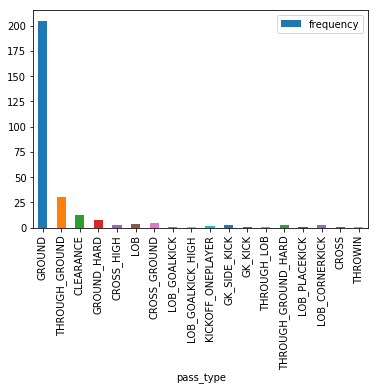

In [268]:
import json

l = []
for i in range(df_plot.shape[0]):

    js = df_plot['event_params'][i]
    d = json.loads(js)
    l.append(d['type'])

freq = {}
for i in range(len(l)):
    my_list = l[i]

    if (my_list in freq): 
        freq[my_list] += 1
    else:
        freq[my_list] = 1
                
passdf = pd.DataFrame.from_dict(list(freq.items()))
passdf.columns = ['pass_type', 'frequency']

## plotting the pass name and its frequency in a bar chart

# passdf.xticks(rotation=90)
passdf.plot(kind = "bar",x='pass_type', y='frequency', rot=90)

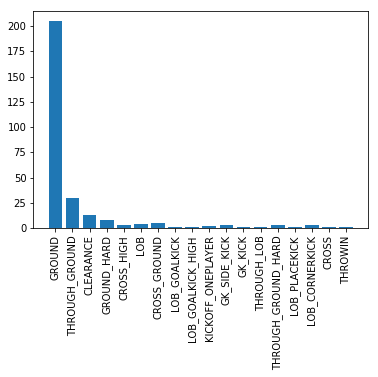

In [273]:
plt.xticks(rotation=90)
plt.bar(passdf['pass_type'], passdf['frequency'])
plt.savefig('Compare.png',dpi=600,bbox_inches='tight')

In [290]:
import pandas as pd
projectid = "prady89-195311"

query= """

with table0 as 
(select Severity, BugId,DATETIME_DIFF(min(PARSE_DATETIME('%I:%M %p %m-%d-%Y',DateAssigned)), min(PARSE_DATETIME('%I:%M %p %m-%d-%Y',CreatedTime_local)), day) Days
from EASports.joinedtables
where ProgressStatusName like "%Closed%"
group by Severity, BugId
order by BugId
)

select count(*) as Number_of_bugs, Days
from table0
group by Days
order by Days

"""

dfBugdays = pd.read_gbq(query, projectid, dialect='standard')

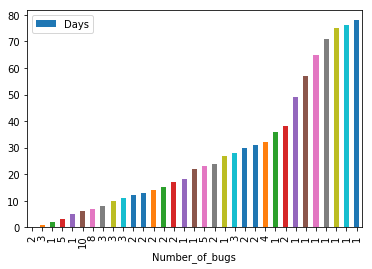

In [292]:
dfBugdays.plot(kind = "bar",x='Number_of_bugs', y='Days', rot=90)

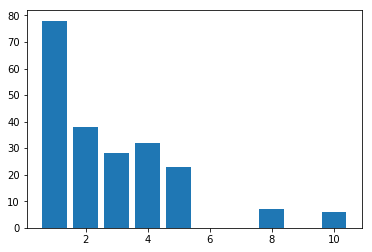

In [294]:
# plt.xticks(rotation=90)
plt.bar(dfBugdays['Number_of_bugs'], dfBugdays['Days'])
plt.savefig('Compare2.png',dpi=600,bbox_inches='tight')